In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipas.collection_no_db.iceagg_collection as collect
import matplotlib.pyplot as plt
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask
import pandas as pd
from dask import dataframe as dd
import pickle

In [3]:
def start_client(num_workers):
    '''start dask client for parallelization'''
    cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='10000MiB', #1 GiB = 1,024 MiB
    processes=1)

    #cluster.adapt(minimum=3, maximum=20)
    cluster.scale(num_workers)
    client = Client(cluster)
    return client

In [4]:
def write_file(filename, agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds):
    '''write results to file'''
    results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs,
              'phi2Ds': phi2Ds,' cplxs': cplxs, 'dds': dds}
    print('saving results to ', filename)
    filehandler = open(filename, 'wb')
    pickle.dump(results, filehandler)
    filehandler.close()
    print('done writing!')

In [5]:
def compute(phioarr, reqarr, nclusters, ncrystals,
            rand_orient, use_dask=False, num_workers=2,
            plot=False):
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    cplxs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    dds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))

    output = np.empty((len(phioarr),len(reqarr), nclusters),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            for n in range(nclusters):
                if use_dask:
                    output[phi,r,n] = dask.delayed(collect.collect_clusters_iceagg)(phioarr[phi], reqarr[r],
                                                                                    ncrystals, rand_orient,
                                                                                    plot=plot)
                else:
                    agg_as[phi,r,n], agg_bs[phi,r,n], agg_cs[phi,r,n], phi2Ds[phi,r,n], cplxs[phi,r,n], dds[phi,r,n] = collect.collect_clusters_iceagg(phioarr[phi], reqarr[r],
                                                                                       ncrystals, rand_orient,
                                                                                       plot=plot)
    if use_dask:
        #start dask client
        client = start_client(num_workers)
        gather = client.compute([*output.tolist()])
        gather = client.gather(gather)
        gather = np.array(gather)
        agg_as = gather[:,:,:,0,:]
        agg_bs = gather[:,:,:,1,:]
        agg_cs = gather[:,:,:,2,:]
        phi2Ds = gather[:,:,:,3,:]
        cplxs = gather[:,:,:,4,:] 
        dds = gather[:,:,:,5,:]

    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds
    


In [6]:
def main():
    # monomer aspect ratios (all the same in agg)
    #phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [10.]
    # monomer radii 
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [100,200]
    # how many aggregates to produce
    nclusters = 3
    # number of monomers per aggregate
    ncrystals = 5
    # monomer orientation - random (True) or flat (False)
    rand_orient = True

    # save aggregate attributes to pickled file
    save = False
    #savename (relative path)
    if save:
        filename = '../../instance_files/test'
        
    # parallelize IPAS using dask
    use_dask = False
    if use_dask:
        num_workers = 5
        agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds = compute(phioarr, reqarr, nclusters, ncrystals,
                                                             rand_orient, use_dask=use_dask,
                                                             num_workers=num_workers)
    else:
        # plot the aggregate?
        plot = True
        agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds = compute(phioarr, reqarr, nclusters,
                                                             ncrystals, rand_orient, plot=plot)

    if save:
        write_file(filename, agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds)
    print('DONE!')

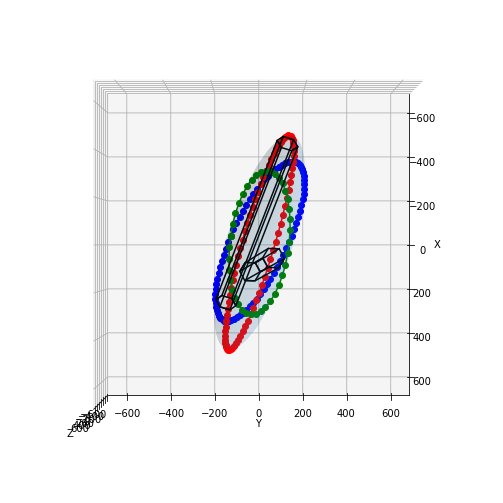

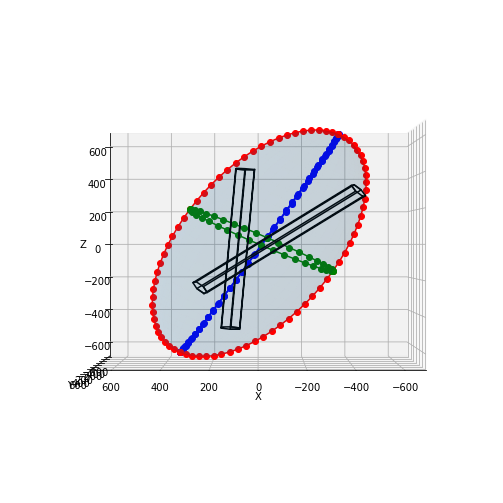

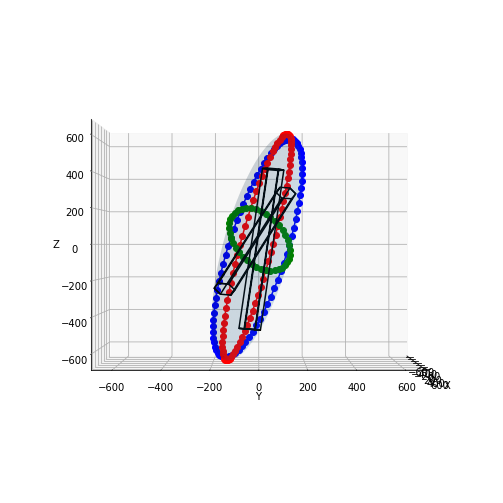

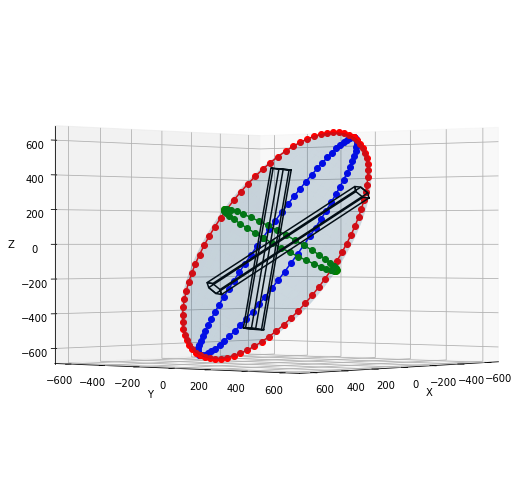

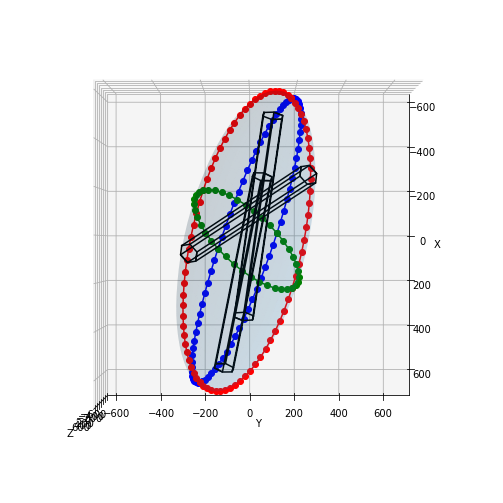

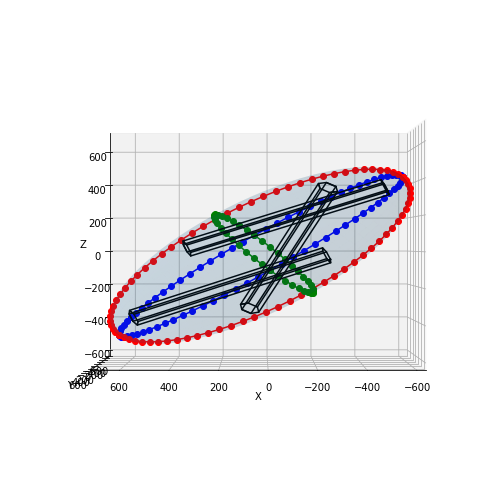

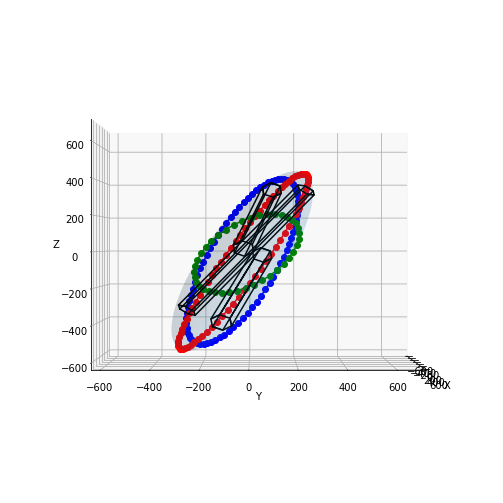

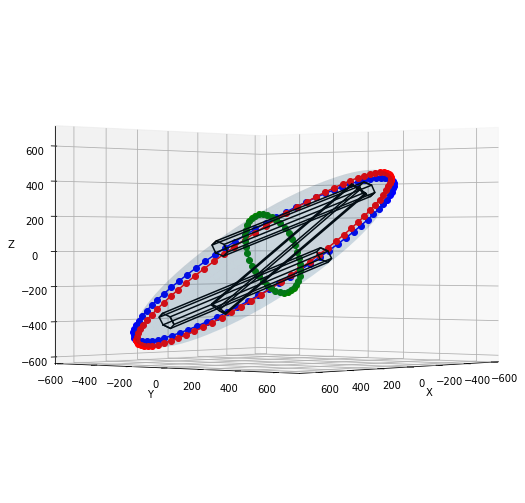

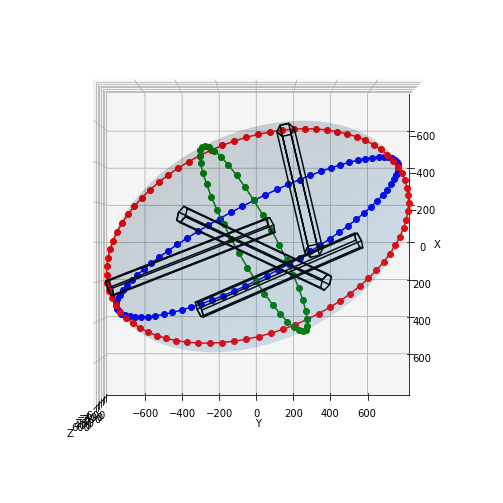

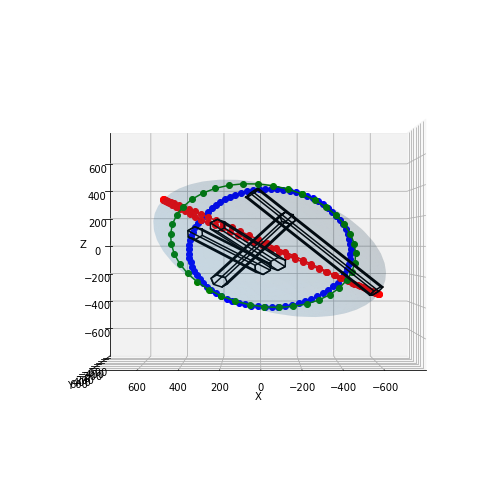

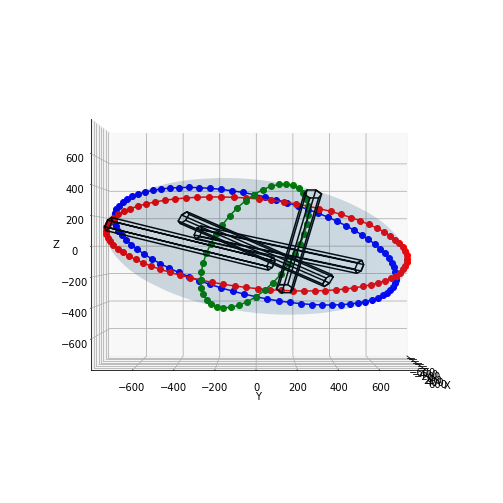

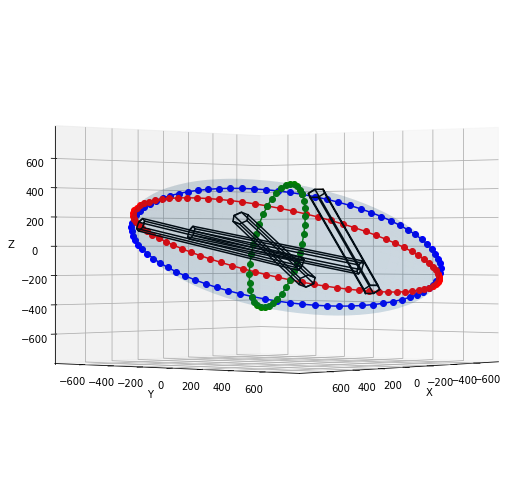

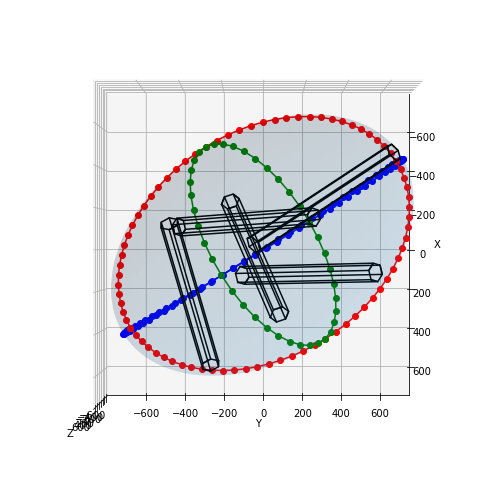

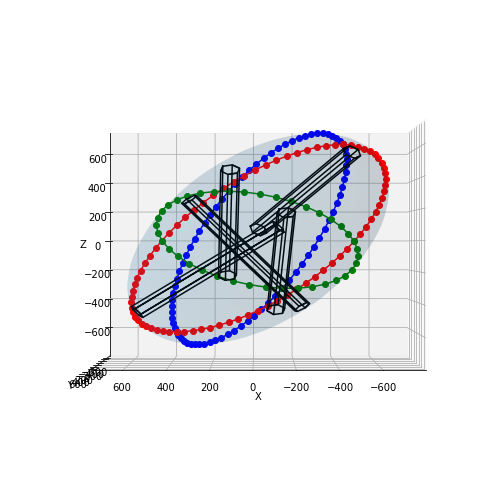

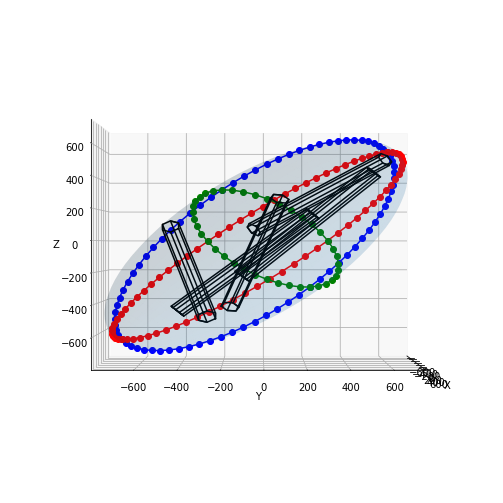

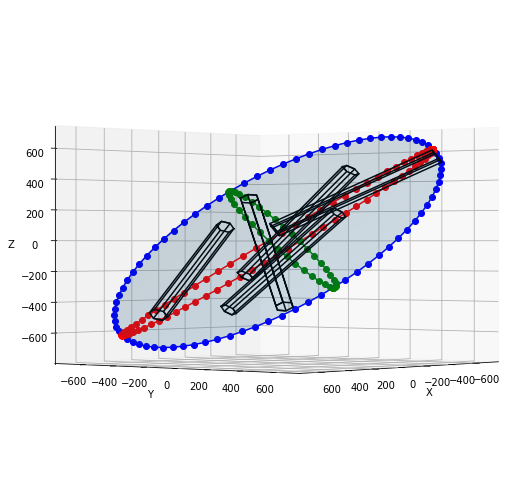

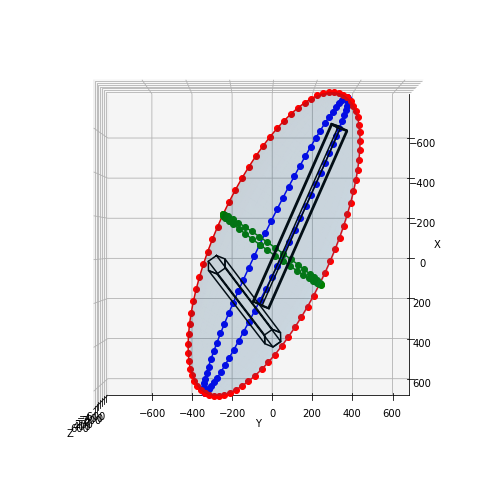

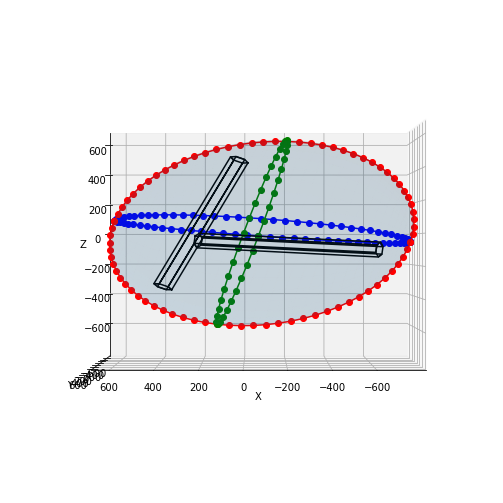

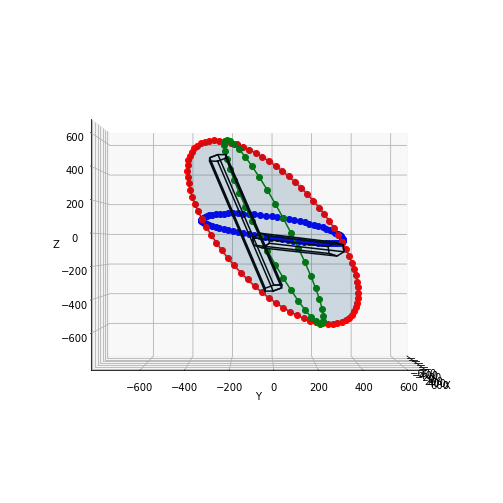

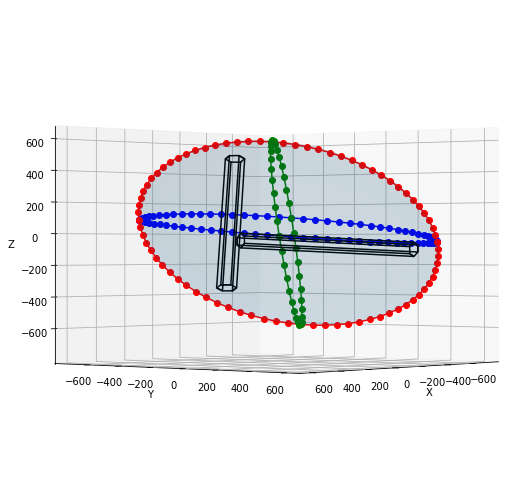

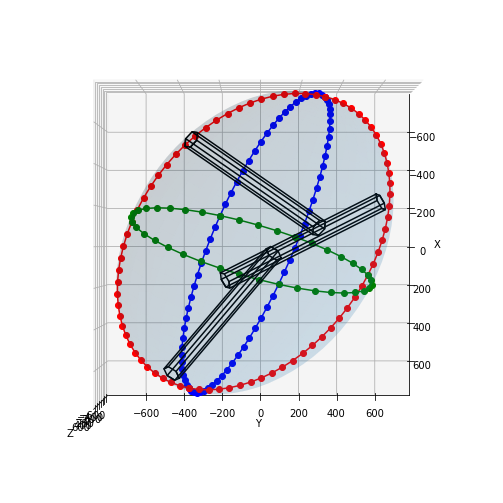

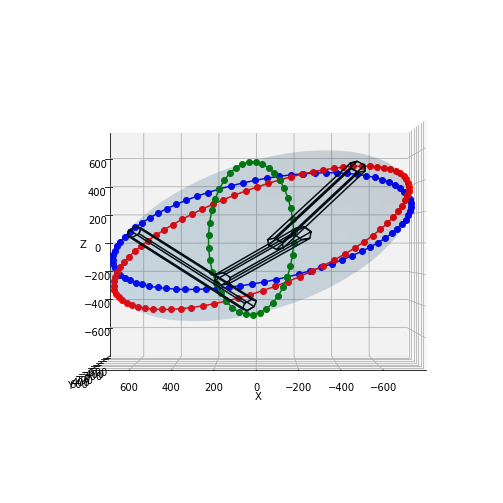

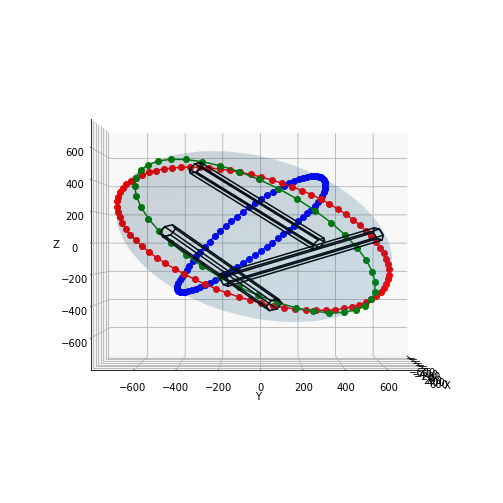

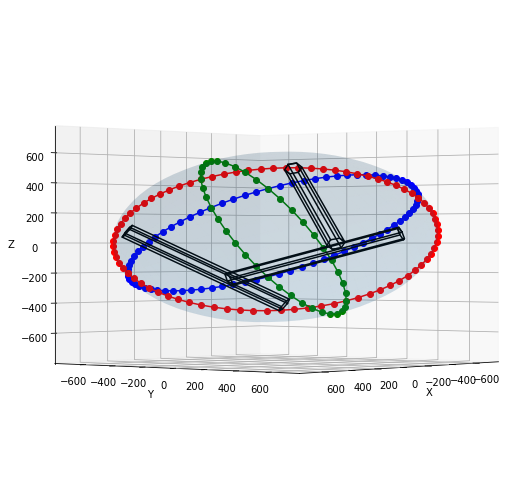

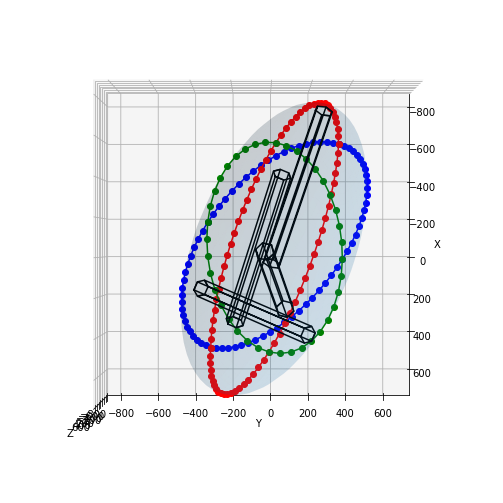

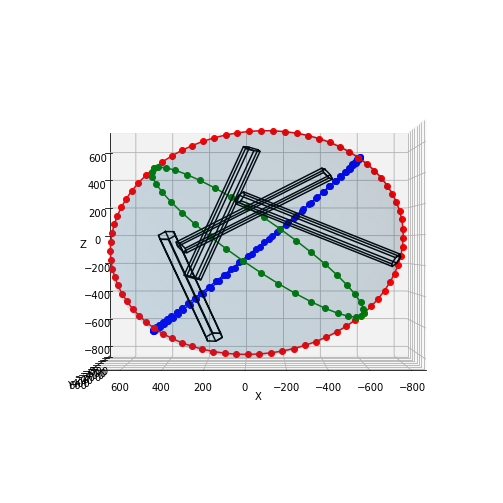

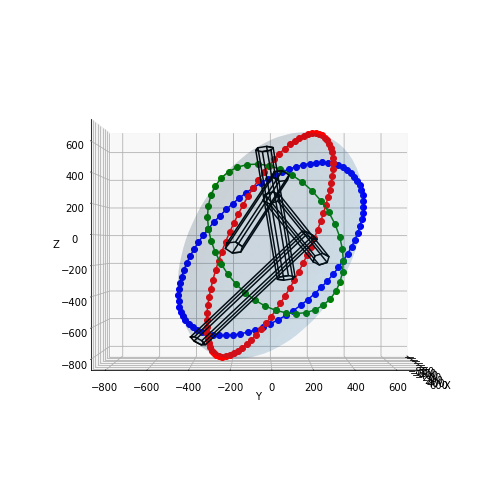

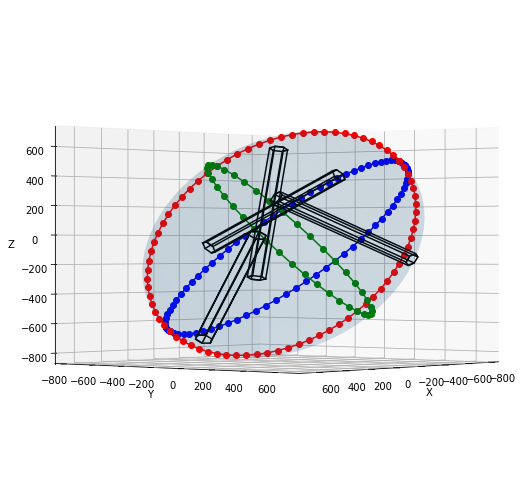

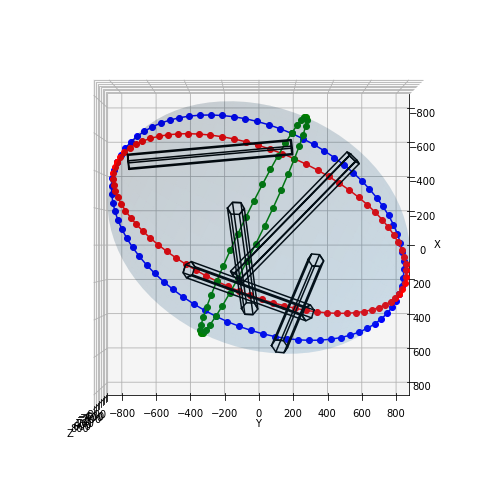

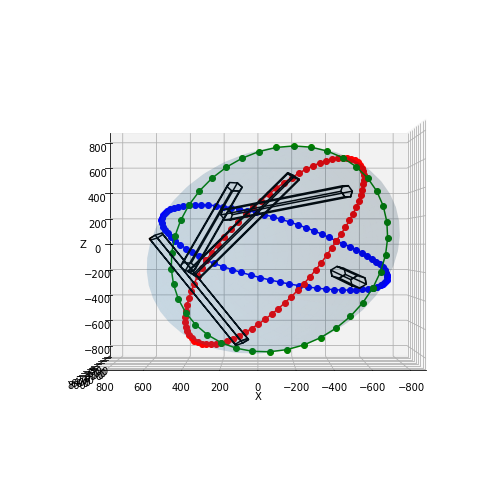

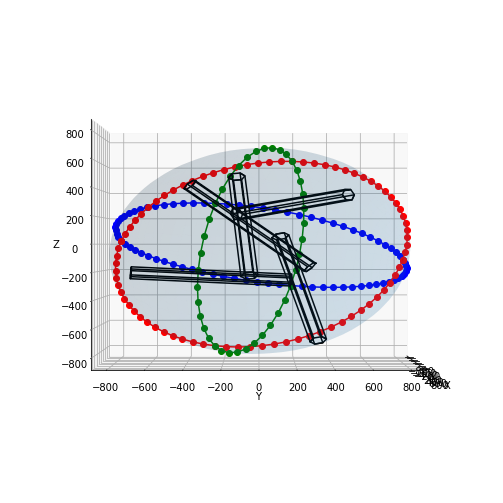

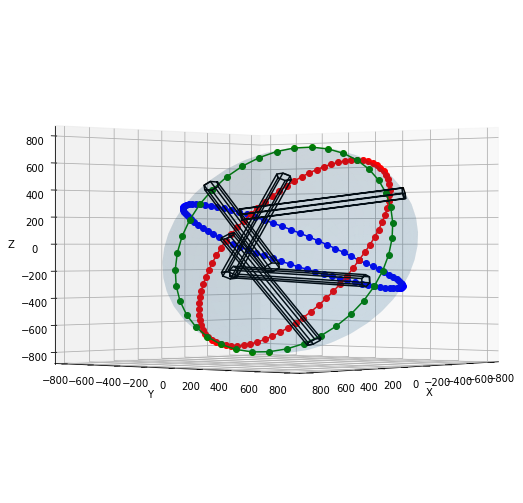

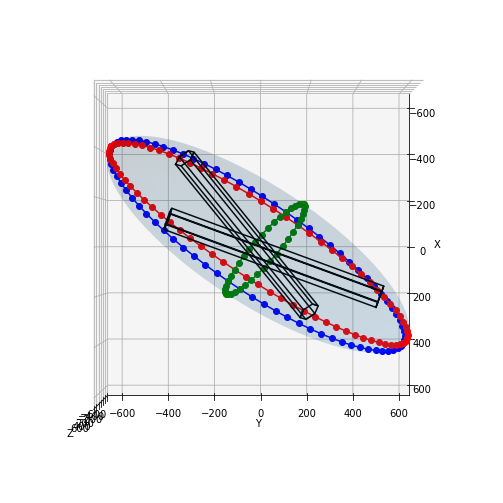

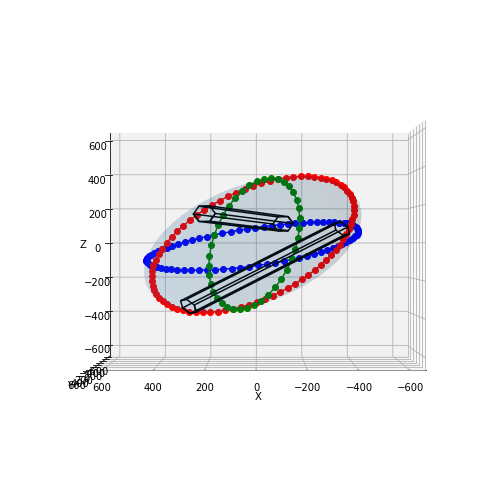

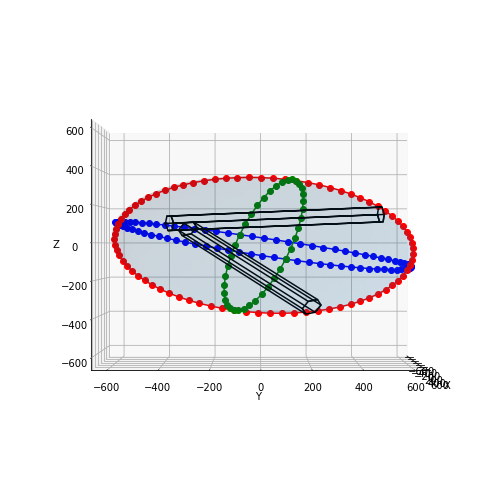

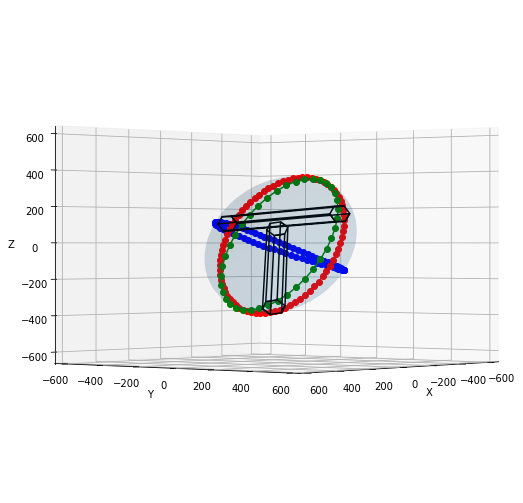

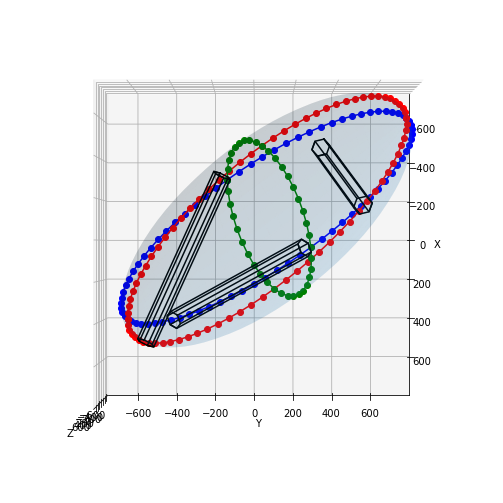

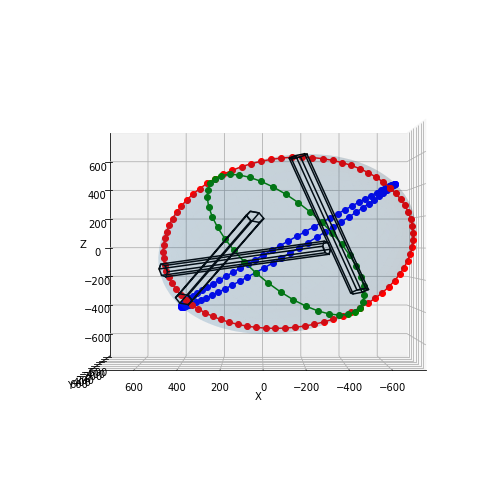

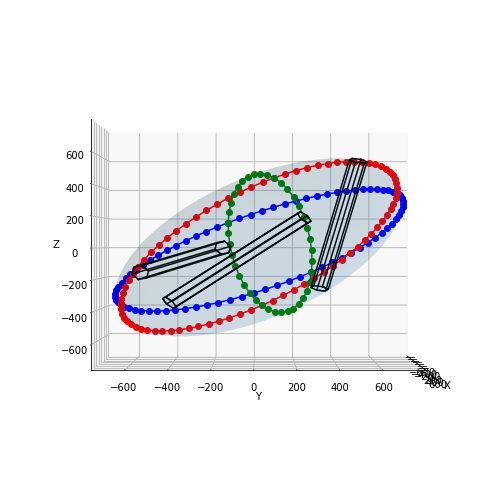

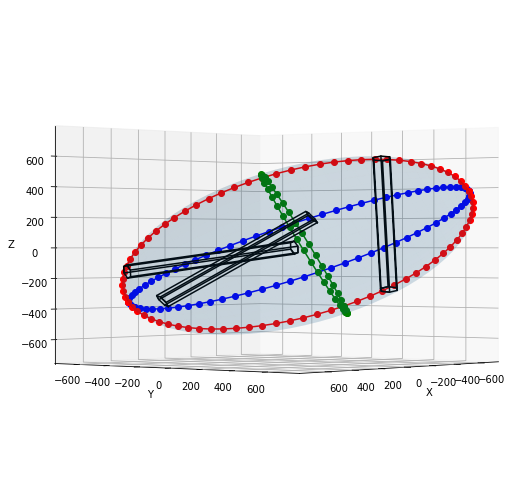

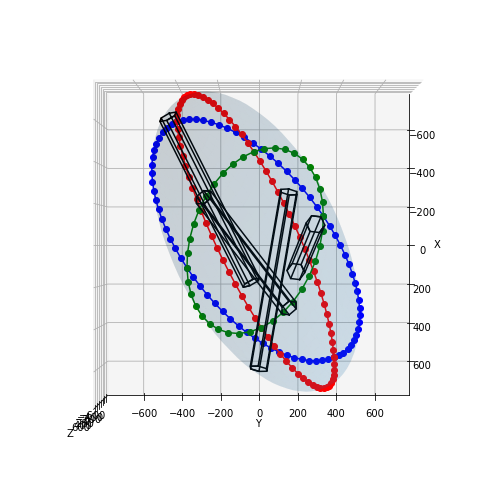

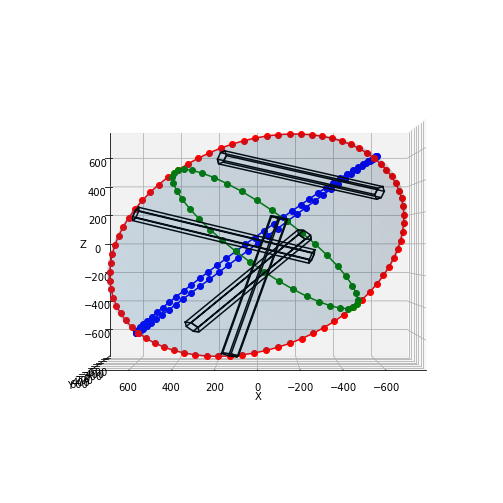

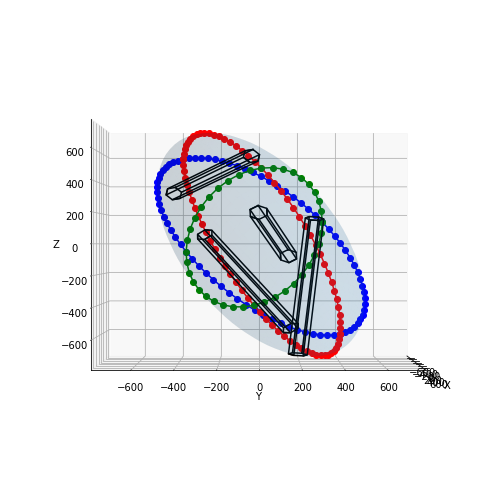

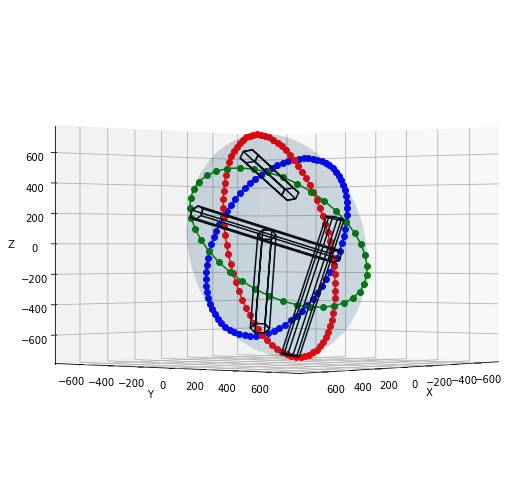

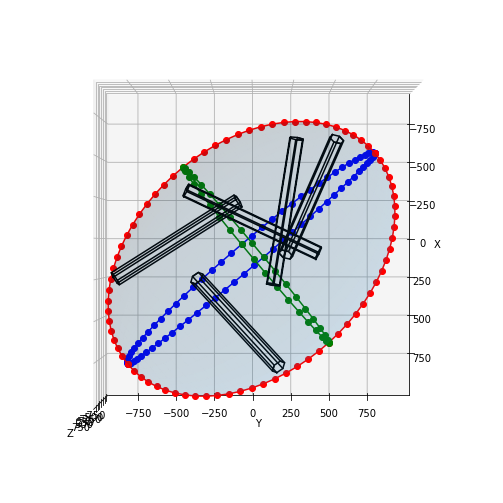

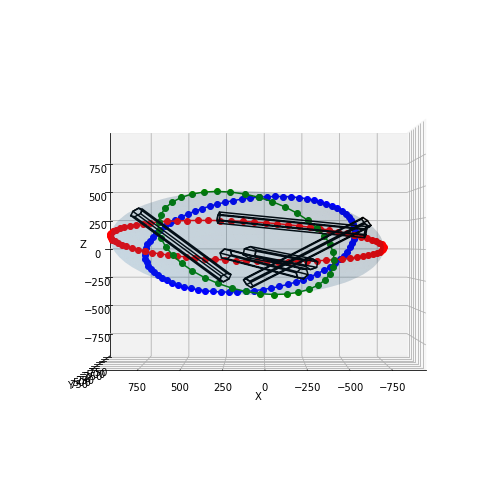

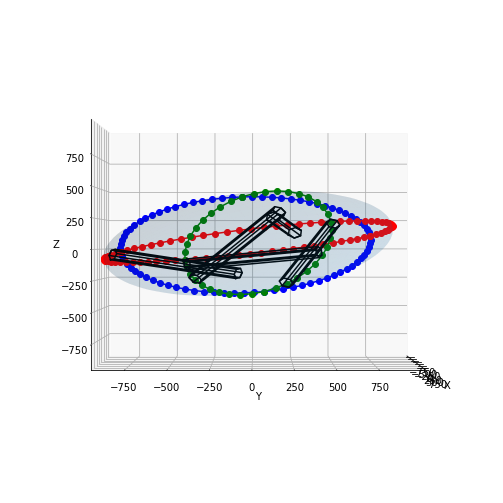

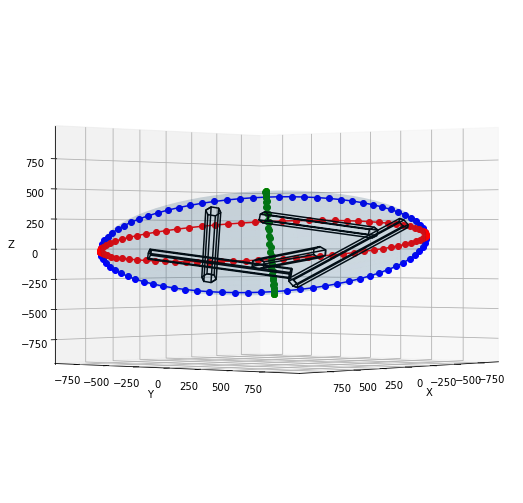

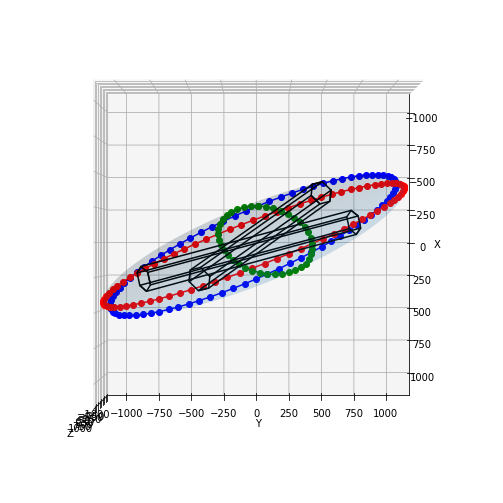

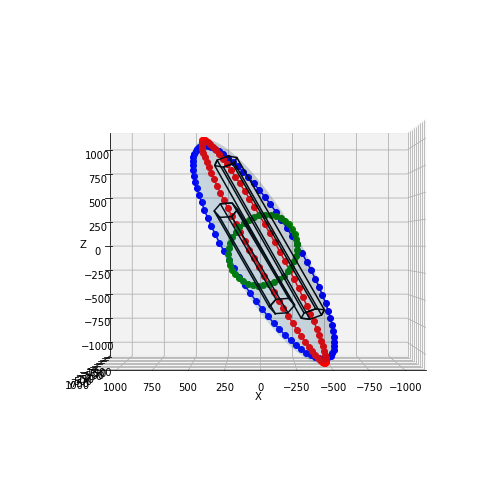

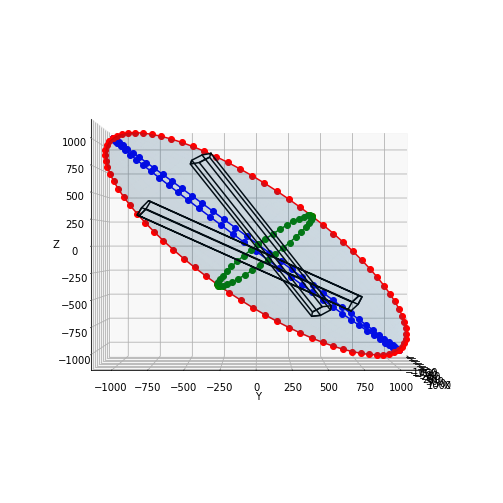

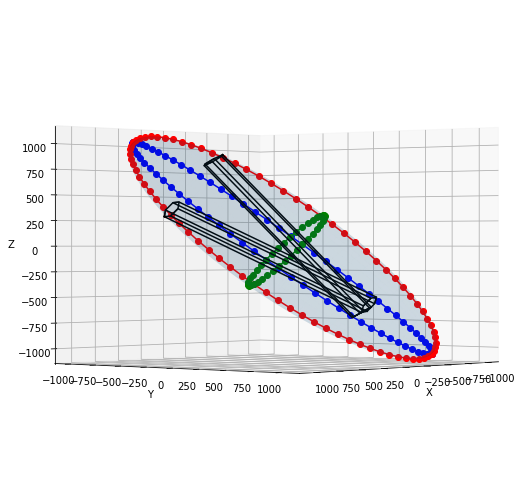

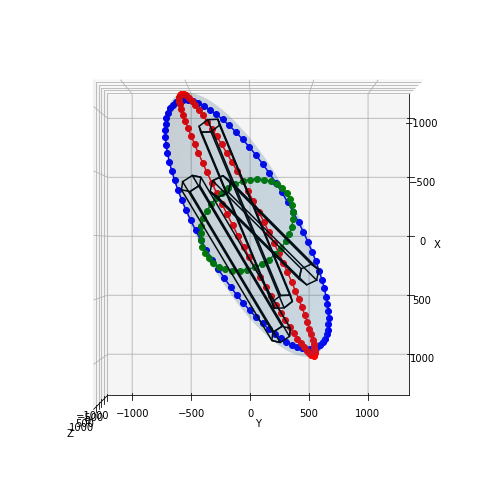

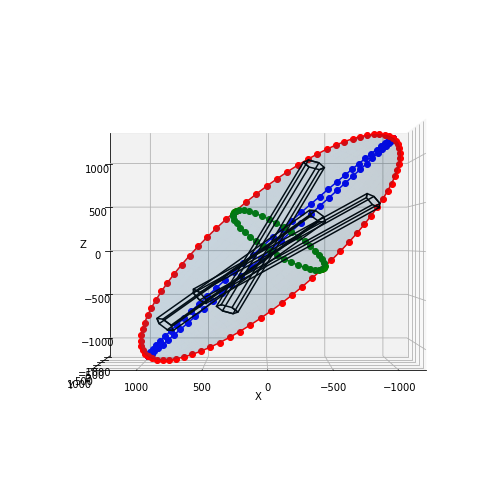

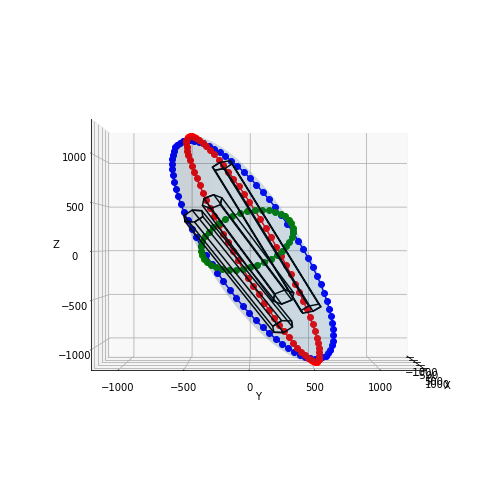

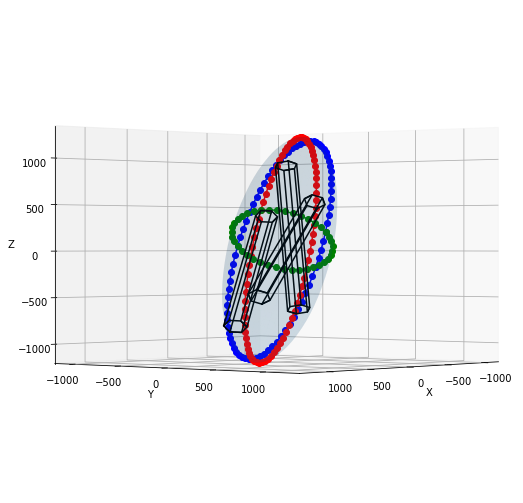

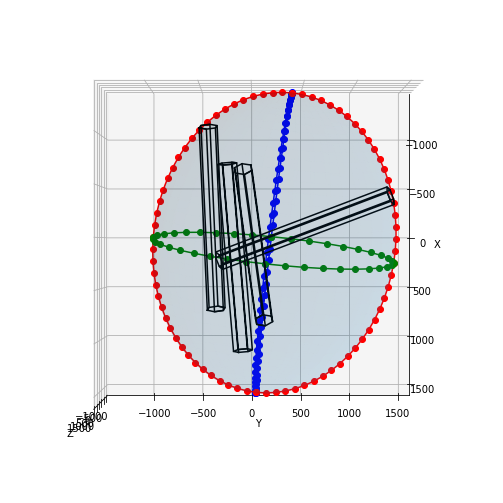

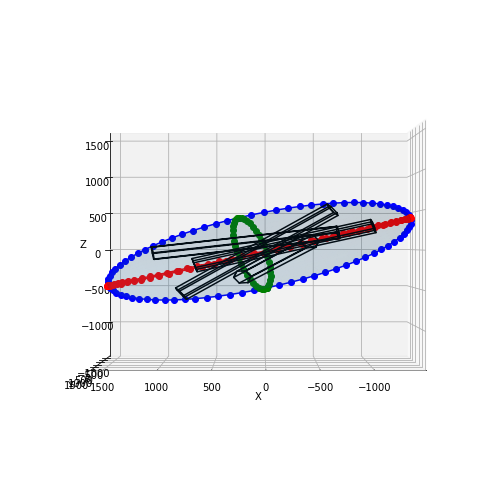

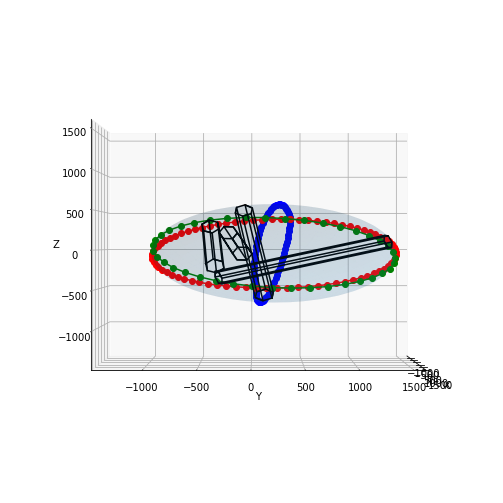

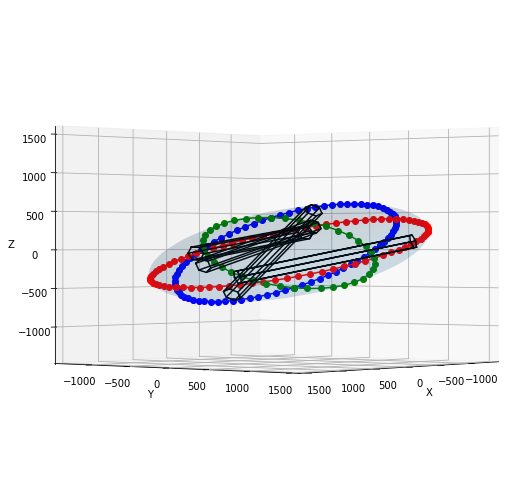

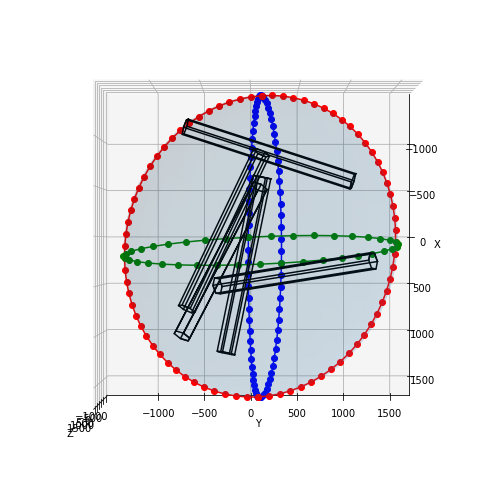

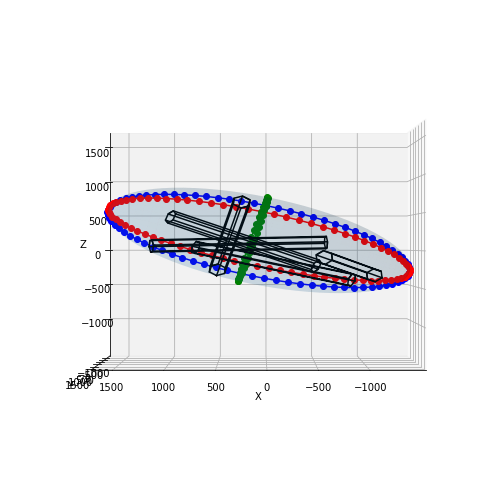

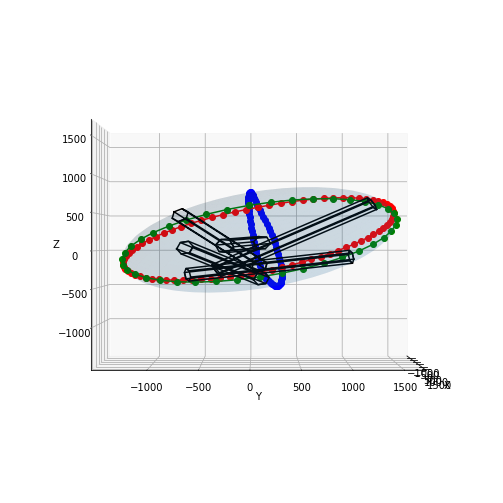

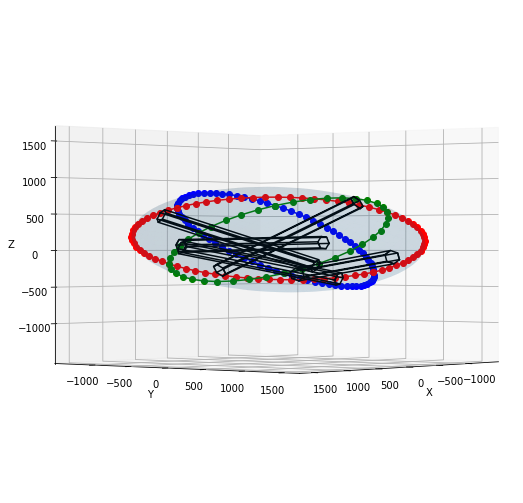

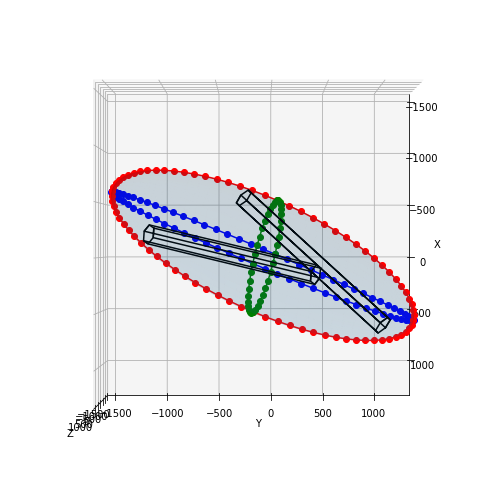

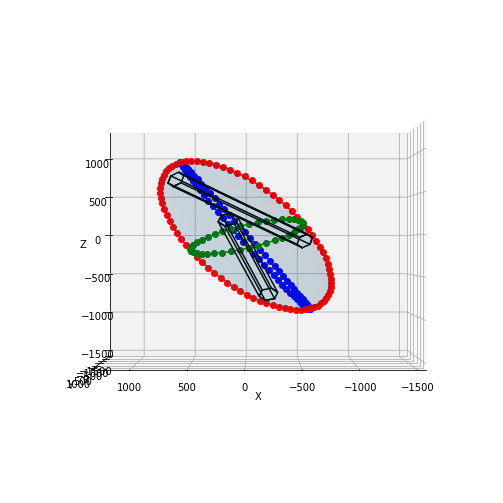

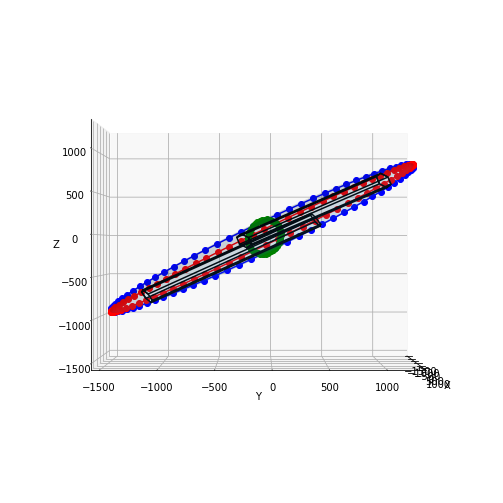

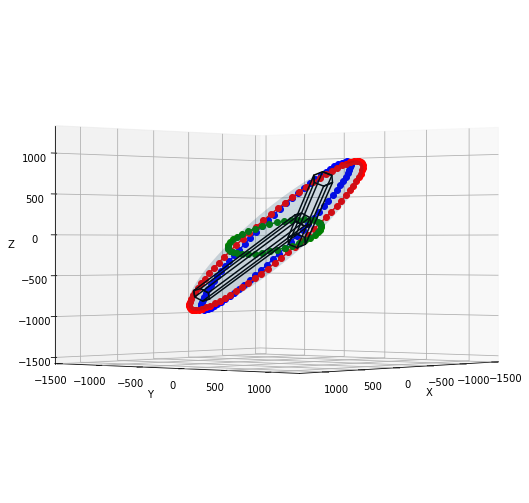

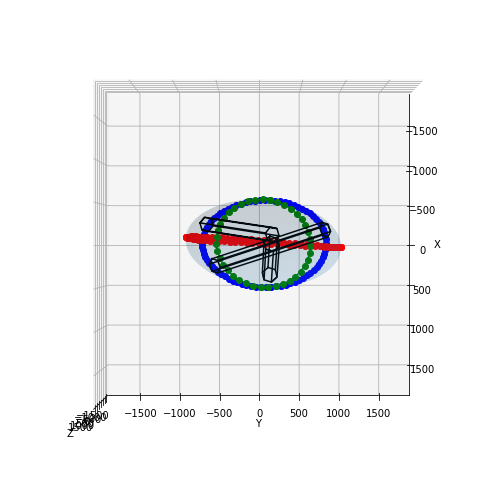

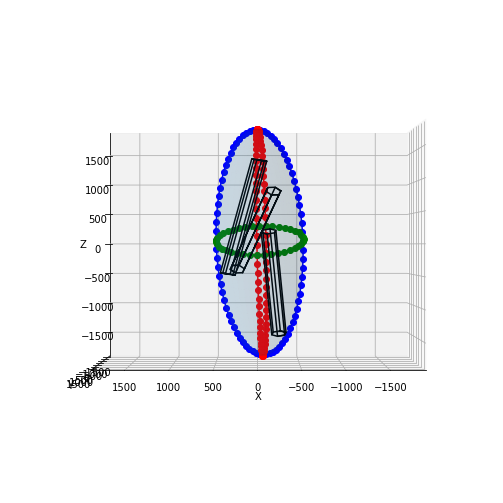

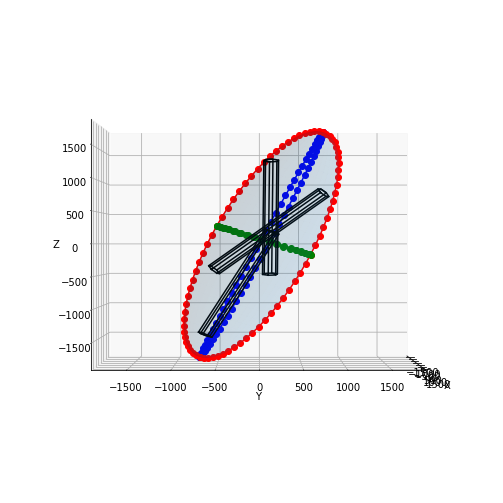

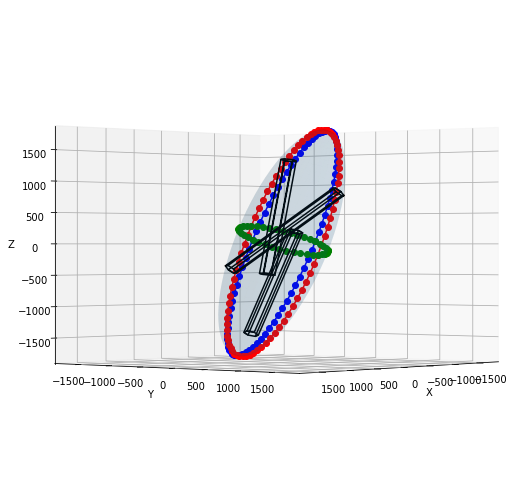

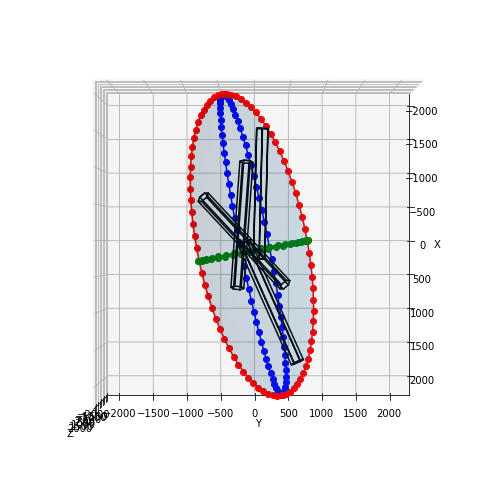

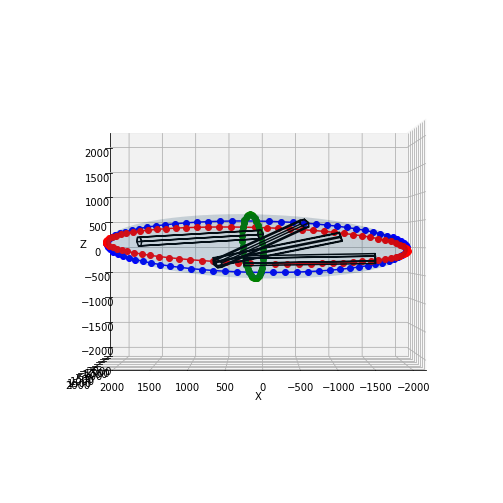

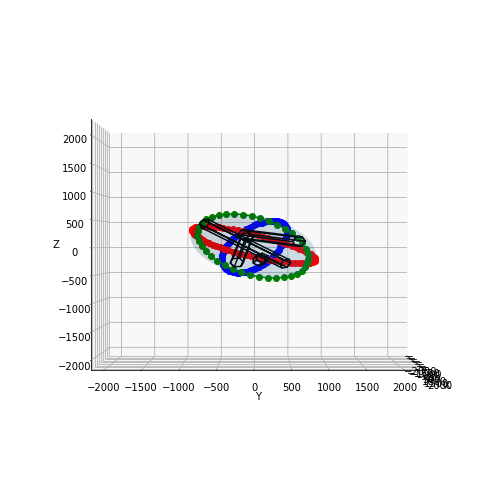

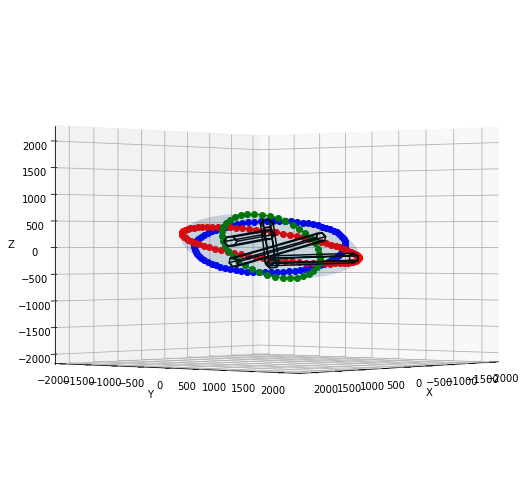

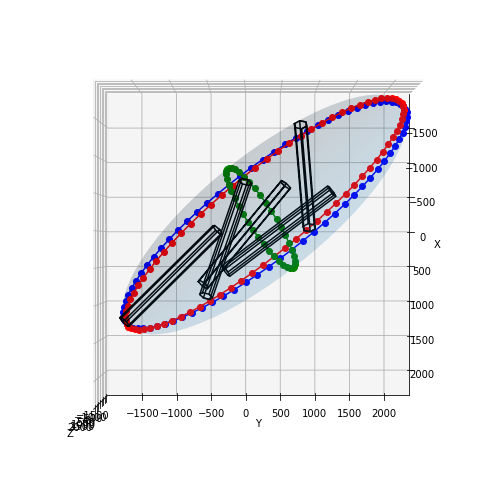

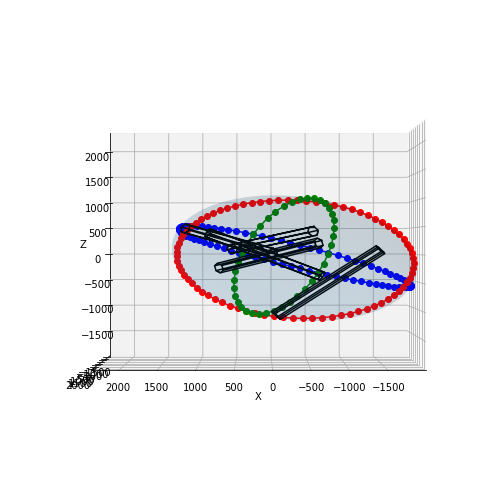

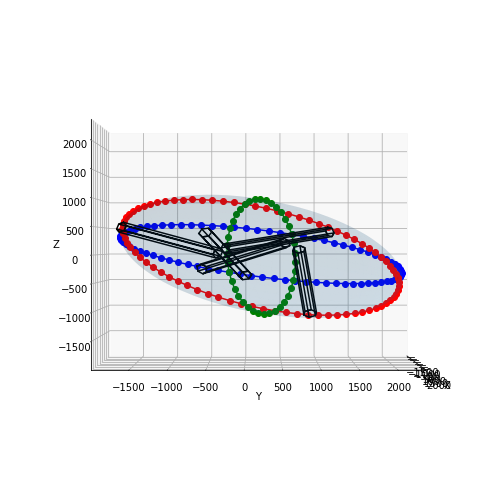

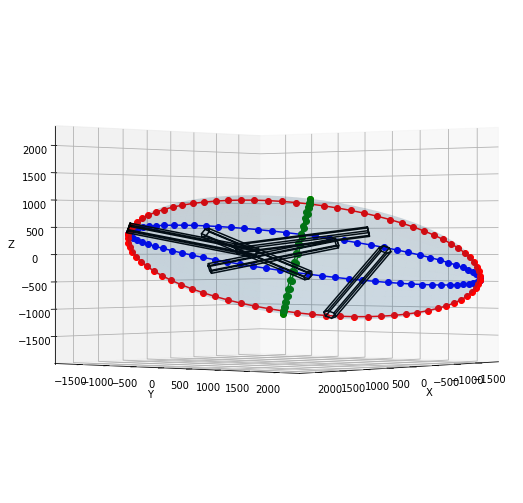

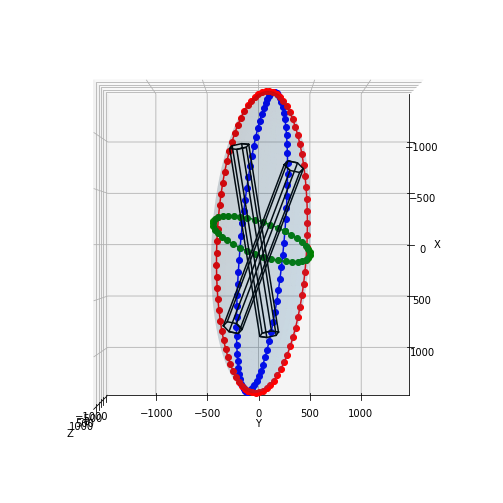

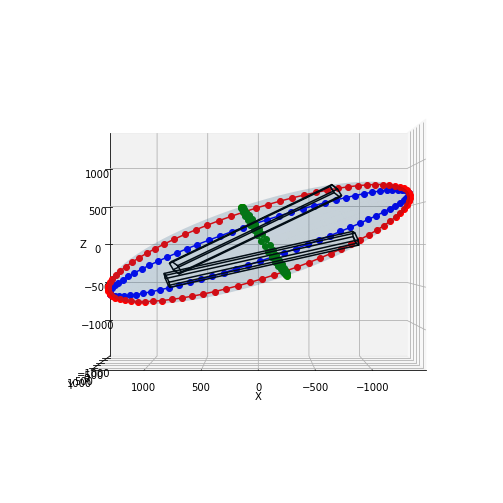

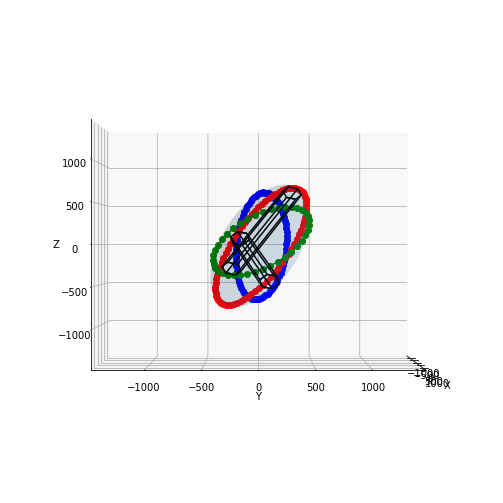

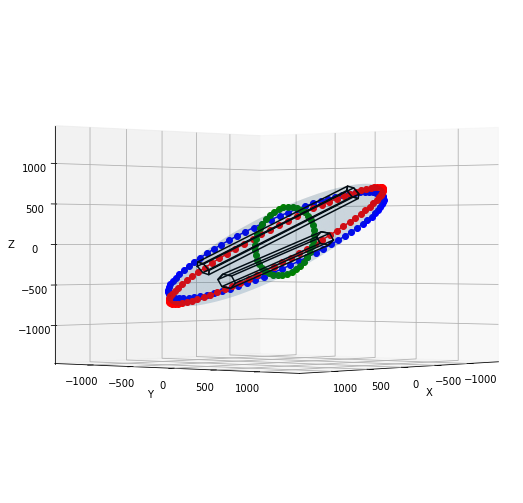

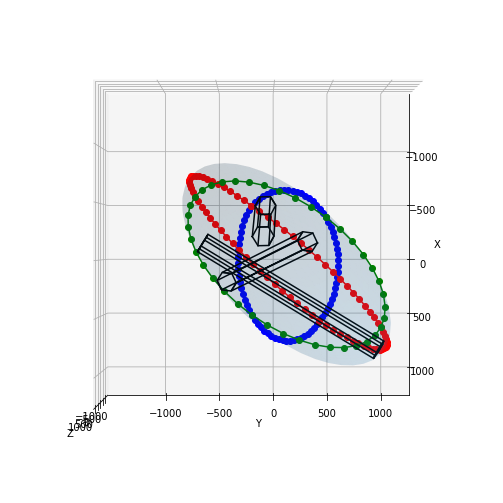

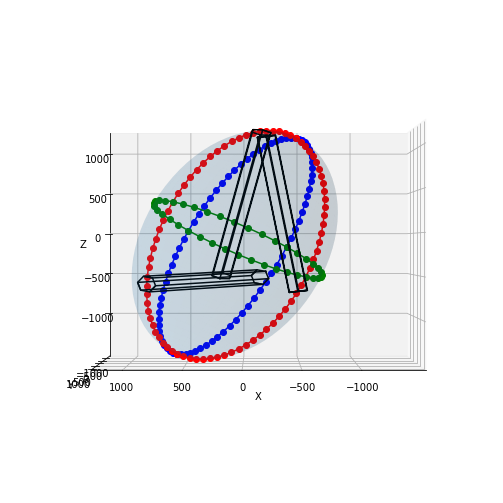

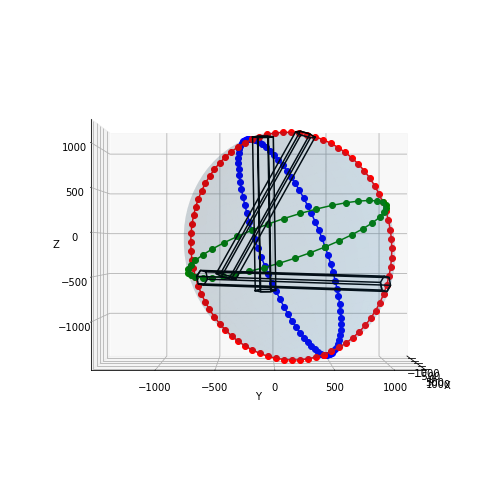

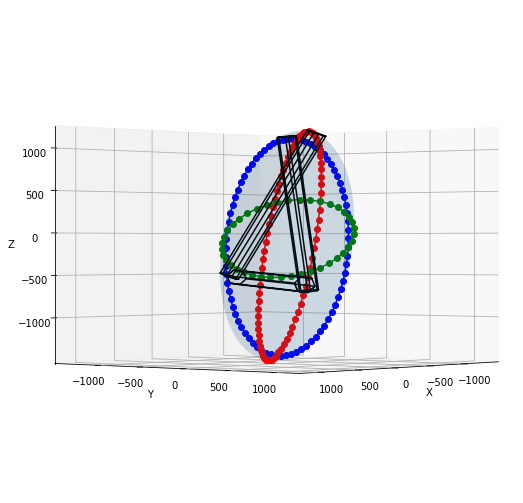

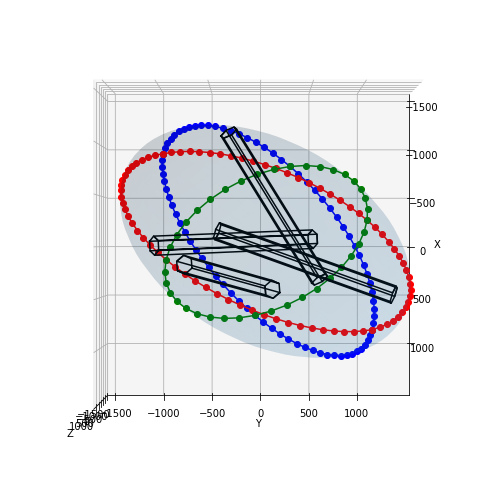

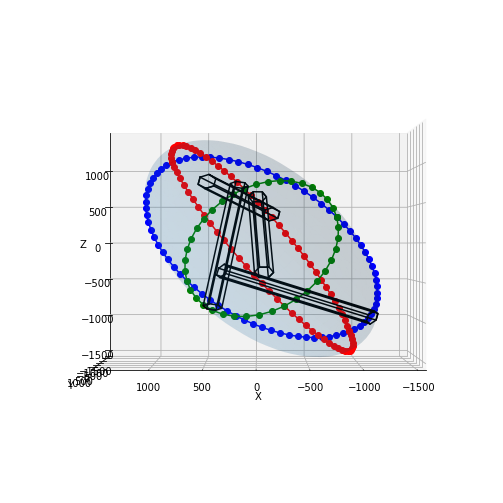

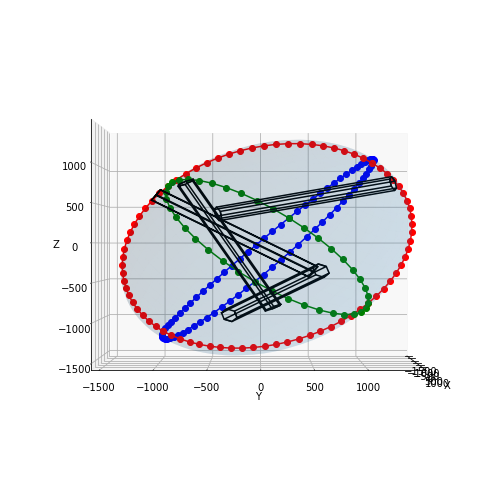

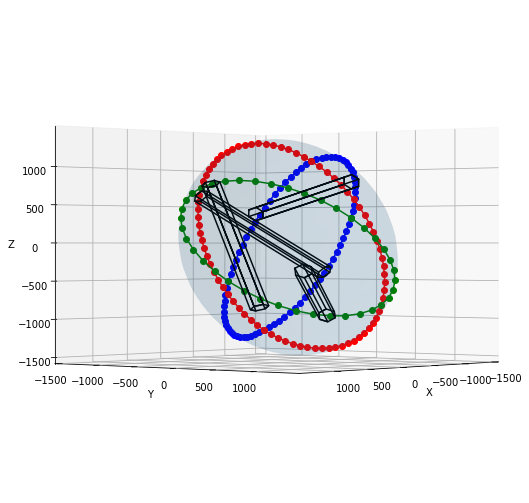

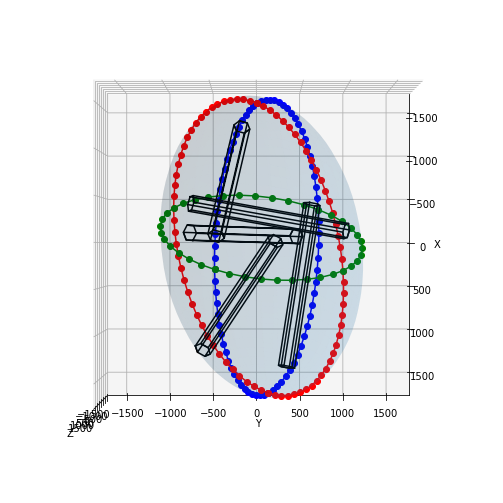

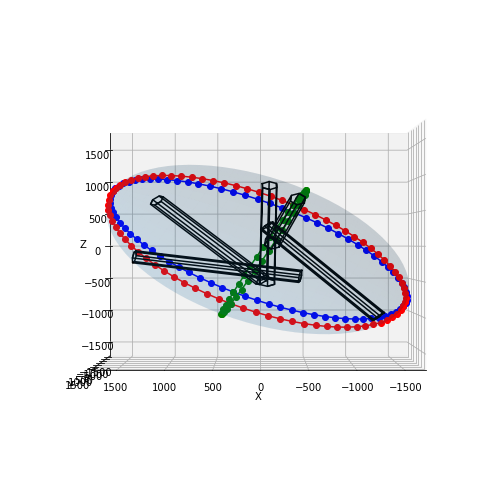

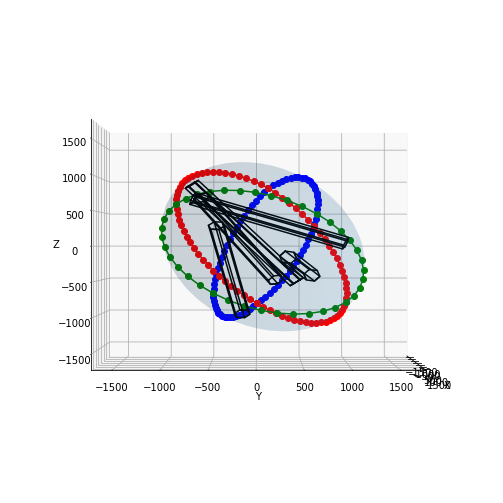

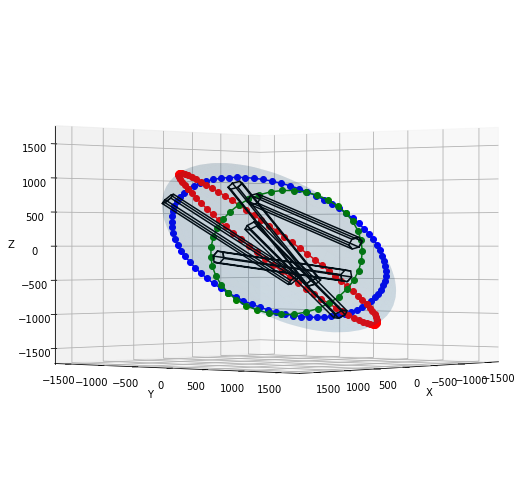

DONE!


In [7]:
if __name__ == '__main__':
    main()